<h3 style="font-size:60px;color:powderblue;">Biomechanics Intern Exercise</h3>

<body style="font-size:20px;color:rgb(255, 255, 255);">
<p>
This exercise was created by Ben Hansen, Product Engineering Lead for the Olympic technology group at Intel. 
Initially, I planned to complete this exercise as part of my application for the Biomechanics Intern position,
however after struggling for a month to complete the project, I decided to look elsewhere after graduation. 

I came back to the exercise to practice my coding in Python and to revisit some of the math that I had
completely forgotten, and slowly chipped away at this project for the past couple of months inbetween classes
and work. Here is the original deliverable:


A tab-delimited text file containing x/y/z positional data of baseball bat markers is provided (in units 
of millimeters). Data was collected using an optical motion capture laboratory at 480 fps. The primary 
objective of the exercise is to programmatically read in the position coordinates of the bat markers, derive, 
and calculate key biomechanical variables of the baseball bats motion. Any programming language can be used 
(Matlab, Python, or C are preferred).

Please derive and calculate the following time series variables of the bats motion. Use any filtering 
techniques deemed appropriate, and derive as many functions as you can from scratch.

- Bat Tip Linear Velocity (x, y, z component and magnitude)
- Bat Tip Linear Acceleration (x, y, z component and magnitude)
- Bat Euler Angles (roll, pitch, yaw)
- Bat Angular Velocity (x, y, z component and magnitude)
- Bat Angular Acceleration (x, y, z component and magnitude)

The final deliverables from the exercise should include the following. Deliverables will be evaluated based on 
biomechanical accuracy, programming efficiency, programming clarity, and presentation quality:

- Source code
- Theory of Operation: Report showing derivations and methods used to calculate swing biomechanics.
- Data and Results: Report showing figures of time-series variables calculated and any relevant discussion.
</p> 
</body>

<h3 style="font-size:40px;color:powderblue;">Packages + Read CSV</h3>

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R
from scipy import stats

# Manually create columns for the txt file
columns = ['Index',
           'x-bat handle', 'y-bat handle', 'z-bat handle',
           'x-bat hands', 'y-bat hands', 'z-bat hands',
           'x-bat COM', 'y-bat COM', 'z-bat COM',
           'x-bat top cap', 'y-bat top cap', 'z-bat top cap',
           'x-bat bottom cap', 'y-bat bottom cap', 'z-bat bottom cap',
           'x-virtual marker end', 'y-virtual marker end', 'z-virtual marker end',
           'x-virtual marker center', 'y-virtual marker center', 'z-virtual marker center']
# Read txt file and organize columns
df = pd.read_csv('/workspaces/Biomechanics-Projects-2022-2023/Bat Data Calculations/Bat_Data.csv', delimiter="\t", skiprows=3, names=columns)


<h3 style="font-size:40px;color:powderblue;">Identify the Global Axis</h3>

<p>
I used a 3D axplot to identify the global axis orientation, which I identified as 'xyz'
</p> 

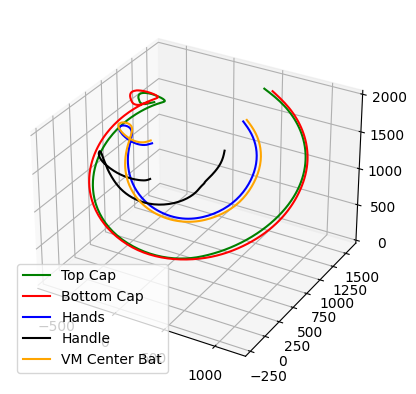

In [11]:
#Figuring out global axis

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot3D(df['x-bat top cap'], df['y-bat top cap'], df['z-bat top cap'], 'green', label = 'Top Cap')
ax.plot3D(df['x-bat bottom cap'], df['y-bat bottom cap'], df['z-bat bottom cap'], 'red', label = 'Bottom Cap')
ax.plot3D(df['x-bat hands'], df['y-bat hands'], df['z-bat hands'], 'blue', label = 'Hands')
ax.plot3D(df['x-bat handle'], df['y-bat handle'], df['z-bat handle'], 'black', label = 'Handle')
ax.plot3D(df['x-virtual marker center'], df['y-virtual marker center'], df['z-virtual marker center'], 'orange', label = 'VM Center Bat')
ax.legend()
ax.set_zlim(zmin=0)
plt.show()

<h3 style="font-size:40px;color:powderblue;">Bat Tip Linear Velocity (x, y, z component and magnitude)</h3>

In [12]:
# Bat Tip Linear Velocity

df_velo = pd.DataFrame()

# We will need at linear time constant in frames per second, which is 480fps in this case
linear_time_constant = 1 / 480

# x linear velo calculation

df_velo['x_bat_top_cap_velo'] = df[['x-bat top cap']].diff() / 1000 / linear_time_constant

# y linear velo calculation - same as x with y values

df_velo['y_bat_top_cap_velo'] = df[['y-bat top cap']].diff() / 1000 / linear_time_constant

# y linear velo calculation - same as x and y with z values

df_velo['z_bat_top_cap_velo'] = df[['z-bat top cap']].diff() / 1000 / linear_time_constant

# velocity magnitude

velocity_squared = (df_velo['x_bat_top_cap_velo'] ** 2 + df_velo['y_bat_top_cap_velo'] ** 2 + df_velo['z_bat_top_cap_velo'] ** 2)
df_velo['velocity mag'] = (velocity_squared ** (1 / 2))

print(df_velo)

     x_bat_top_cap_velo  y_bat_top_cap_velo  z_bat_top_cap_velo  velocity mag
0                   NaN                 NaN                 NaN           NaN
1             -0.183559           -0.589805            0.140156      0.633409
2             -0.184776           -0.588134            0.140332      0.632248
3             -0.186768           -0.585323            0.140566      0.630273
4             -0.189053           -0.581836            0.140859      0.627786
..                  ...                 ...                 ...           ...
691          -14.325176            3.664277            6.762188     16.259298
692          -14.432417            3.289571            6.654375     16.229499
693          -14.524394            2.988457            6.567539     16.217937
694          -14.594268            2.775645            6.506074     16.218072
695          -14.632793            2.665078            6.473965     16.221390

[696 rows x 4 columns]


<h3 style="font-size:40px;color:powderblue;">Bat Tip Linear Acceleration (x, y, z component and magnitude)</h3>

In [13]:
#Bat Tip Linear Acceleration 

df_acc = pd.DataFrame()

# x linear acceleration calculation, finding the difference between velocities

df_acc['x_bat_top_cap_acc'] = df_velo['x_bat_top_cap_velo'].diff() / linear_time_constant

# y linear acc calculation - same as x with y values

df_acc['y_bat_top_cap_acc'] = df_velo['y_bat_top_cap_velo'].diff() / linear_time_constant

# z linear acc calculation - same as x and y with z values

df_acc['z_bat_top_cap_acc'] = df_velo['z_bat_top_cap_velo'].diff() / linear_time_constant

# acceleration magnitude calculation
acceleration_squared = (df_acc['x_bat_top_cap_acc'] ** 2 + df_acc['y_bat_top_cap_acc'] ** 2 + df_acc['z_bat_top_cap_acc'] ** 2)
df_acc['acceleration mag'] = (acceleration_squared ** (1 / 2))

print(df_acc)

     x_bat_top_cap_acc  y_bat_top_cap_acc  z_bat_top_cap_acc  acceleration mag
0                  NaN                NaN                NaN               NaN
1                  NaN                NaN                NaN               NaN
2            -0.583834           0.801792           0.084557          0.995431
3            -0.956160           1.349683           0.112205          1.657853
4            -1.096934           1.673626           0.140774          2.006017
..                 ...                ...                ...               ...
691         -57.206246        -208.743782         -59.568538        224.488156
692         -51.475968        -179.859226         -51.750144        194.106140
693         -44.149018        -144.534528         -41.681203        156.769539
694         -33.539098        -102.149914         -29.503181        111.489522
695         -18.492365         -53.071949         -15.412378         58.276416

[696 rows x 4 columns]


<h3 style="font-size:40px;color:powderblue;">Euler Angles</h3>

<p>
This is where I got stuck for a long time, it took me a fair bit of hours to finally get something that would work to calculate euler angles. Ultimately, I calculated vectors i, j, and k to get rotation matrices for all of the frames. This is where I decided to cop out and used spicy.spatial.transform to calculate the euler angles from the rotation matrices, rather than manually calculate the angles. In the future I might try and write out code for that purpose, but for now this works just the same. 
</p> 

In [14]:
# Euler angles

df2 = pd.DataFrame()

#Vector Handle to VM bat end i

vector_bt_x = df['x-virtual marker end'] - df['x-bat handle']
vector_bt_y = df['y-virtual marker end'] - df['y-bat handle']
vector_bt_z = df['z-virtual marker end'] - df['z-bat handle']

mag_bt = ((vector_bt_x ** 2) + (vector_bt_y ** 2) + (vector_bt_z ** 2)) ** (1 / 2)

df2['ix'] = vector_bt_x / mag_bt
df2['iy'] = vector_bt_y / mag_bt
df2['iz'] = vector_bt_z / mag_bt

# Vector n or Handle to Hands

vector_n_x = df['x-bat hands'] - df['x-bat handle']
vector_n_y = df['y-bat hands'] - df['y-bat handle']
vector_n_z = df['z-bat hands'] - df['z-bat handle']

mag_n = ((vector_n_x ** 2) + (vector_n_y ** 2) + (vector_n_z ** 2)) ** (1 / 2)

df2['vector_n_x'] = vector_n_x / mag_n
df2['vector_n_y'] = vector_n_y / mag_n
df2['vector_n_z'] = vector_n_z / mag_n

# Cross product of both Vectors, |i| and |n|, to calculate k

i_array = df2[['ix', 'iy', 'iz']].to_numpy()
n_array = df2[['vector_n_x', 'vector_n_y', 'vector_n_z']].to_numpy()
k_array = np.cross(i_array, n_array)

# Vector j, using k and i

j_array = np.cross(k_array, i_array)

#Create a dataframe with i, j, and k
dfi = pd.DataFrame(i_array, columns=['i_x','i_y','i_z'])
dfj = pd.DataFrame(j_array, columns=['j_x','j_y','j_z'])
dfk = pd.DataFrame(k_array, columns=['k_x','k_y','k_z'])

df3 = pd.DataFrame()
df3 = pd.concat([dfi, dfj, dfk], axis=1)

#Convert df3 to Rotation Matrices

rotationmatrix = np.array(df3)
rmatrix = rotationmatrix.reshape((696,3,3))

#Rotation matrix to euler angles
r = R.from_matrix(rmatrix)
euler = r.as_euler('xyz', degrees=True)

#Display euler angles
df4 = pd.DataFrame(euler, columns=['Roll','Pitch','Yaw'])

print(df4)

           Roll      Pitch         Yaw
0    147.732288  58.718314  121.947020
1    147.751622  58.801563  122.053977
2    147.768829  58.883662  122.158534
3    147.781068  58.963497  122.257592
4    147.785872  59.040213  122.348476
..          ...        ...         ...
691  -20.290116  19.120679  -80.127473
692  -21.355839  19.782712  -82.179870
693  -22.472839  20.444836  -84.250287
694  -23.640796  21.100750  -86.338797
695  -24.856832  21.740479  -88.442079

[696 rows x 3 columns]


<h3 style="font-size:40px;color:powderblue;">Bat Angular Velocity (x, y, z component and magnitude)</h3>

In [15]:
#Angular Velocity

#Euler degrees to radians
euler_rad = np.deg2rad(euler)
dfrad = pd.DataFrame(euler_rad,columns=['x','y','z'])

angular_velocity_x = dfrad[['x']].diff() / 1000 / linear_time_constant
angular_velocity_y = dfrad[['y']].diff() / 1000 / linear_time_constant
angular_velocity_z = dfrad[['z']].diff() / 1000 / linear_time_constant

df5 = pd.DataFrame()
df5 = pd.concat([angular_velocity_x, angular_velocity_y, angular_velocity_z], axis=1)
df5.loc[0] = pd.Series({'x': 0, 'y': 0, 'z': 0})

#Excluding outliers and interpolating the outliers
df6 = df5[np.abs(df5 - df5.mean()) <= (2 * df5.std())]
df6_interpolated = df6.interpolate()

print(df6_interpolated)

            x         y         z
0    0.000000  0.000000  0.000000
1    0.000162  0.000697  0.000896
2    0.000144  0.000688  0.000876
3    0.000103  0.000669  0.000830
4    0.000040  0.000643  0.000761
..        ...       ...       ...
691 -0.008509  0.005515 -0.017063
692 -0.008928  0.005546 -0.017194
693 -0.009358  0.005547 -0.017345
694 -0.009785  0.005495 -0.017497
695 -0.010187  0.005359 -0.017620

[696 rows x 3 columns]


<h3 style="font-size:40px;color:powderblue;">Bat Angular Acceleration (x, y, z component and magnitude)</h3>

In [16]:
#Angular Acceleration

angular_acceleration_x = df5[['x']].diff() / 1000 / linear_time_constant
angular_acceleration_y = df5[['y']].diff() / 1000 / linear_time_constant
angular_acceleration_z = df5[['z']].diff() / 1000 / linear_time_constant

df7 = pd.DataFrame()
df7 = pd.concat([angular_acceleration_x, angular_acceleration_y, angular_acceleration_z], axis=1)
df7.loc[0] = pd.Series({'x': 0, 'y': 0, 'z': 0})

#Excluding outliers and interpolating the outliers
df8 = df7[np.abs(df7 - df7.mean()) <= (2 * df7.std())]
df8_interpolated = df8.interpolate()

print(df8_interpolated)

            x             y         z
0    0.000000  0.000000e+00  0.000000
1    0.000078  3.347658e-04  0.000430
2   -0.000009 -4.626989e-06 -0.000010
3   -0.000020 -9.104562e-06 -0.000022
4   -0.000030 -1.253921e-05 -0.000033
..        ...           ...       ...
691 -0.000193  2.217896e-05 -0.000046
692 -0.000201  1.478314e-05 -0.000063
693 -0.000206  3.708242e-07 -0.000072
694 -0.000205 -2.497523e-05 -0.000073
695 -0.000193 -6.508615e-05 -0.000059

[696 rows x 3 columns]
